# Gaussian Mixture Model using Expectation Maximization

Ryan Miller

## Importing Libraries

In [1]:
import numpy as np
from PIL import Image
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics.pairwise import euclidean_distances

## Importing the Image

In [2]:
fish = Image.open('Images/fish.jpg')
fish_data = pd.DataFrame(list(fish.getdata()),columns=['R','G','B'])
fish_data.head()

,R,G,B
0,151,191,105
1,150,190,104
2,149,189,103
3,149,187,102
4,148,186,99


In [7]:
print("Number of Pixels:", fish_data.shape[0])

Number of Pixels: 307200


## Expectation Maximization

In [4]:
def em_segmentation(data, num_segments = 10, random_seed = 0,num_iter = 10):
    '''
        - data: the dataframe containing the RGB values of the image
        - num_segments: the number of segments to create from the image    
        - random_seed: the seed used when randomly selecting the RGB values from data 
    '''
    #storing number of observations
    n = len(data)
    
    #storing data as a matrix
    X = np.array(data)
    
    #randomly selecting pixels to use as cluster centers and uniform dist for initial probabilities
    np.random.seed(random_seed)
    indices = np.random.randint(low=0,high=n,size=num_segments)
    segment_means = np.array([data.iloc[i,:] for i in indices])
    segment_probs = np.array([1/num_segments for i in range(num_segments)])

    #setting number of iterations for testing purposes
    #num_iter = 50

    #running for number of iterations
    for _ in tqdm(range(num_iter)):
        '''E-Step'''
        #initializing weights matrix
        weights = np.zeros((n,num_segments))
        
        #need to find the distance between each point and the closest cluster center
        dmin = euclidean_distances(X, segment_means).min(axis = 1)
        
        #iterating through each segment cluster
        for j in range(num_segments): 
            #subtracting means from each observation
            diff = X - segment_means[j]
            #finding posterior probabilities (and subtracting d_min_squared to avoid numerical computation issues)
            weights[:,j] = np.exp(-0.5*(np.sum(diff**2, axis = 1) - dmin**2)) * segment_probs[j]
        
        #dividing each posterior probability for the observations by the sum of all posterior probabilities
        div = np.reshape(np.sum(weights,axis=1),newshape=(n,1))+ 0.1
        weights = weights/div
        
        '''M-Step'''
        #using linear algebra to speed up m-step
        for j in range(num_segments):
            # adjusting segment means using weights calculated above
            segment_means[j] = np.reshape(np.dot(X.T,weights[:,j:j+1])/np.sum(weights[:,j:j+1]),newshape=(1,3))
            
        #adjusting segment probabilities using weights calculated above
        segment_probs = np.sum(weights,axis=0)/n  
        
        #setting last probability to 1 - the rest of the probabilities as recommended by the book
        segment_probs[-1] = 1 - np.sum(segment_probs[:-1])
            
    #Finding Posterior Probabilities for each Observation
    posterior = np.zeros((n,num_segments))
    for j in range(num_segments): 
        diff = X - segment_means[j]
        posterior[:,j] = np.exp(-0.5*np.sum(diff**2,axis=1))*segment_probs[j]
        
    #storing the closest segment number for each observation
    posterior_max = np.argmax(posterior,axis=1)

    #converting floats to integers
    segment_means = segment_means.astype(int)
    
    #creating output dataframe with the segment numbers having the highest posterior probabilities
    output_df = pd.DataFrame([segment_means[i] for i in posterior_max],columns=['R','G','B'])
    output_df['segment'] = posterior_max     
        
    return output_df

## Segmentation of Fish Image

Even though the segmented image only has 50 unique RGB combinations for its 307,200 pixels, it still captures all of the main details from the original.

### Original

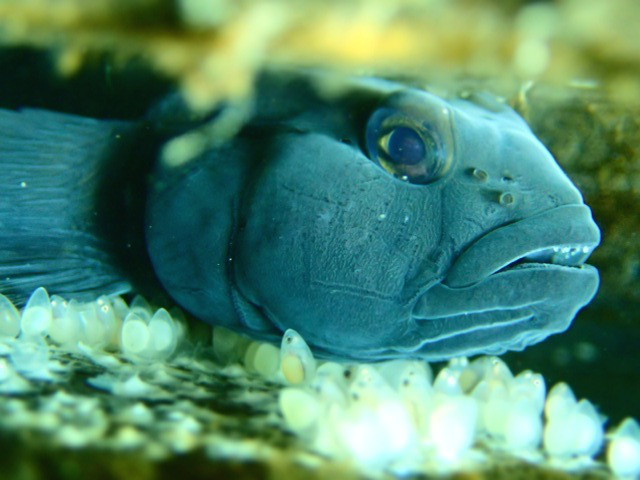

In [5]:
fish

### Segmented

A Jupyter Widget

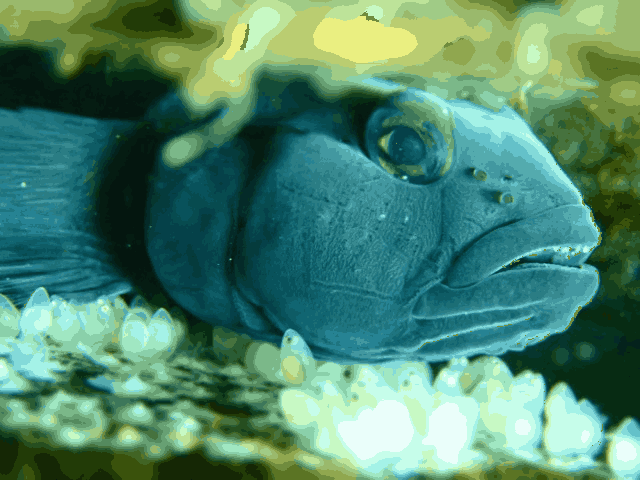

In [6]:
#Fish data with 50 segments
fish_segment_50 = em_segmentation(data=fish_data,num_segments=50, random_seed=0,num_iter=50)
fish_list_50 = [tuple(i) for i in fish_segment_50.iloc[:,:-1].values]
fish_50 = Image.new(fish.mode,fish.size)
fish_50.putdata(fish_list_50)
fish_50